In [58]:
## Imports related to PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

## Generic imports
import os
import time
import sys
import pickle
import random
import argparse
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import hankel
from skimage import io, transform
from matplotlib.backends.backend_pdf import PdfPages

## Dependencies classes and functions
from utils import *
from utils import alignOF
from DyanOF import OFModel
from DyanOF import creatRealDictionary
from skimage import measure


from scipy.misc import imread, imresize
from skimage.measure import compare_mse as mse
from collections import defaultdict
import matplotlib
import scipy.io as sio
import cv2
from matplotlib.colors import hsv_to_rgb
#from sklearn import preprocessing
############################# Import Section #################################
import math
from pylab import imshow, show, get_cmap
#import imutils
import cv2
import scipy
import math
start = time.time()
from pyflow import pyflow

In [59]:
# Hyper Parameters
FRA = 9
PRE = 1
N_FRAME = FRA+PRE
T = FRA
lam = 0.5

def loadModel(ckpt_file):
    loadedcheckpoint = torch.load(ckpt_file)
    #model.load_state_dict(loadedcheckpoint['state_dict'])
    #optimizer.load_state_dict(loadedcheckpoint['optimizer'])
    stateDict = loadedcheckpoint['state_dict']

    # load parameters
    Dtheta = stateDict['l1.theta']
    Drr    = stateDict['l1.rr']
    model = OFModel(Drr, Dtheta, T, PRE, lam, gpu_id)
    model.cuda(gpu_id)
    Drr = Variable(Drr.cuda(gpu_id))
    Dtheta = Variable(Dtheta.cuda(gpu_id))
    dictionary = creatRealDictionary(N_FRAME,Drr,Dtheta, gpu_id)

    return model, dictionary, Drr, Dtheta

def process_im(im, desired_sz=(128, 160)):
    target_ds = float(desired_sz[0])/im.shape[0]
    im = imresize(im, (desired_sz[0], int(np.round(target_ds * im.shape[1]))))
    d = int((im.shape[1] - desired_sz[1]) / 2)
    im = im[:, d:d+desired_sz[1]]
    # im = imutils.resize(im, width=160,height=128)
    return im


def SSIM(predi,pix):
    pix = pix.astype(float)
    predict = predi.astype(float)
    ssim_score = measure.compare_ssim(pix, predict, win_size=11, data_range = 1.,multichannel=True,
                    gaussian_weights=True,sigma = 1.5,use_sample_covariance=False,
                    K1=0.01,K2=0.03)

    return ssim_score


def scipwarp(img, u, v):
    M, N, _ = img.shape
    x = np.linspace(0,N-1, N)
    y = np.linspace(0,M-1, M)
    x, y = np.meshgrid(x, y)
    x += u
    y += v
    warped = img
    warped[:,:,0] = scipy.ndimage.map_coordinates(img[:,:,0], [y.ravel(),x.ravel()], order=1, mode='nearest').reshape(img.shape[0],img.shape[1])
    warped[:,:,1] = scipy.ndimage.map_coordinates(img[:,:,1], [y.ravel(),x.ravel()], order=1, mode='nearest').reshape(img.shape[0],img.shape[1])
    warped[:,:,2] = scipy.ndimage.map_coordinates(img[:,:,2], [y.ravel(),x.ravel()], order=1, mode='nearest').reshape(img.shape[0],img.shape[1])
    return warped

In [60]:
alpha = 0.012
ratio = 0.75
minWidth = 20
nOuterFPIterations = 7
nInnerFPIterations = 1
nSORIterations = 30
colType = 0

import time
current_milli_time = lambda: int(round(time.time() * 1000))

gpu_id = 0
ckpt_file = '/home/armandcomas/DYAN/preTrainedModel/' \
              'Kitti_ChaseOF_not-std_lam01_lossFuPRE_FRA9-PRE1_Comp-ori_70.pth'
rootDir = '/home/armandcomas/datasets/Caltech/images'

## Load model from a checkpoint file

folderList = ['set10V011'] # set10V011
__imgsize__ = (128,160)
mse = []
ssim = []
psnr = []
c_list = []

set10V011
1733
25


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


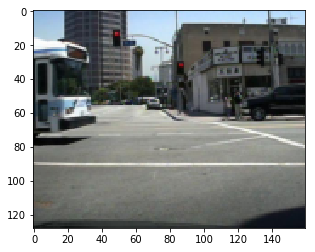

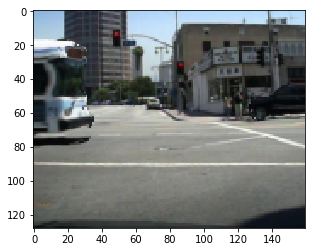

26


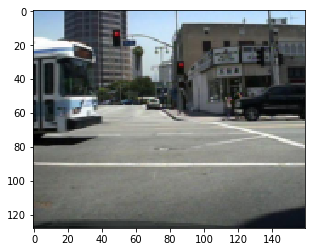

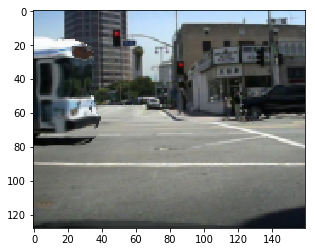

27


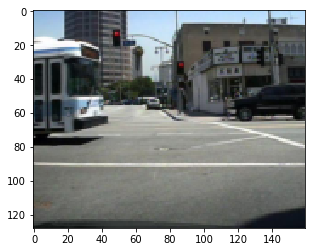

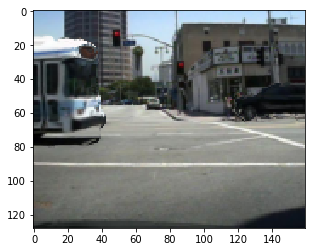

28


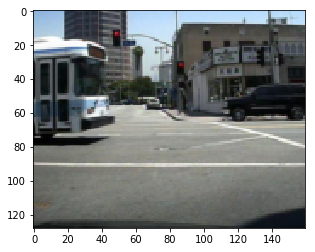

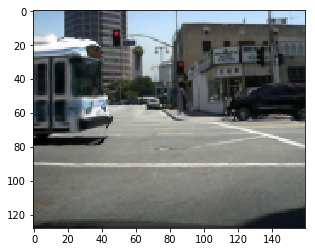

29


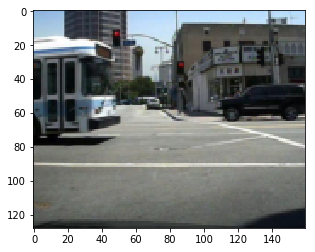

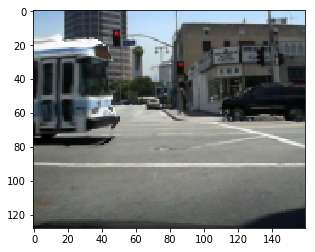

30


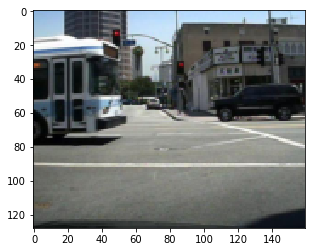

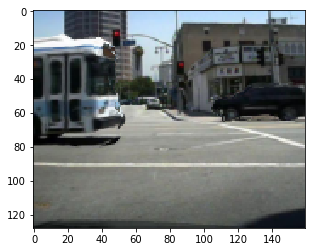

31


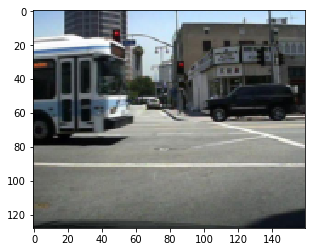

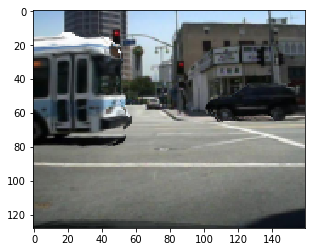

32


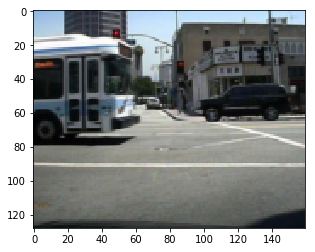

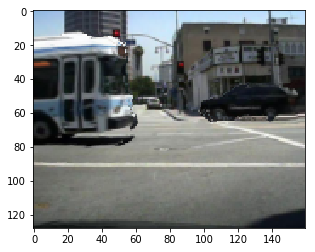

33


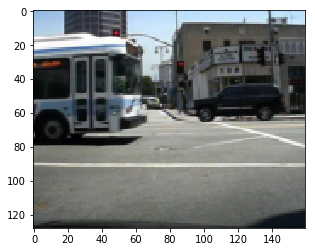

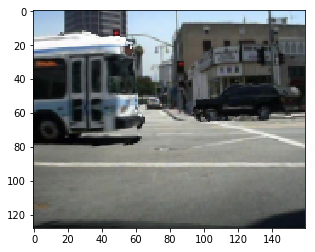

34


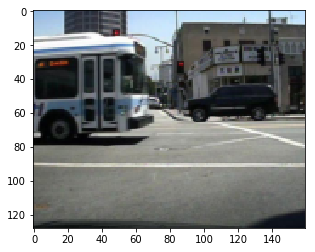

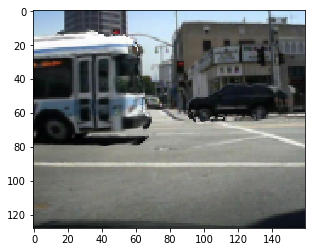

35


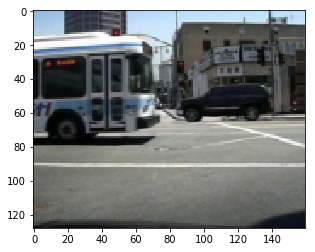

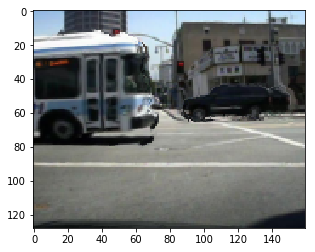

36


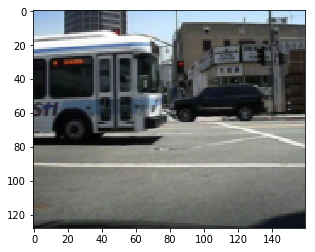

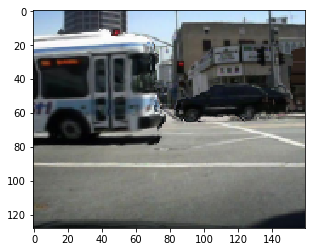

37


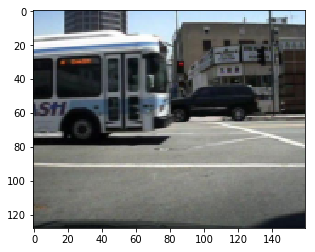

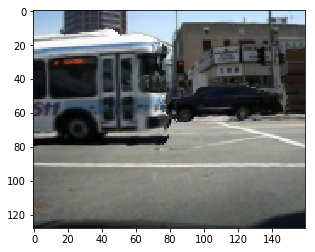

38


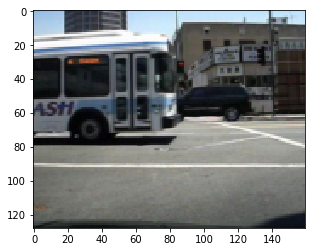

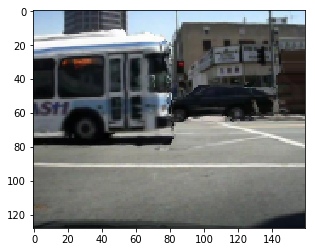

39


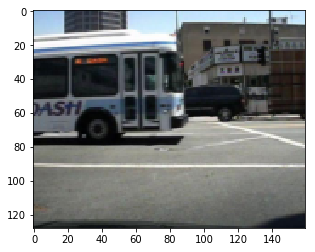

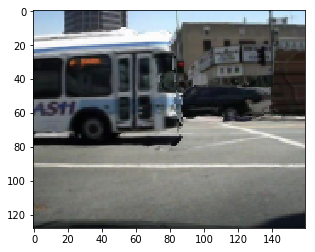

40


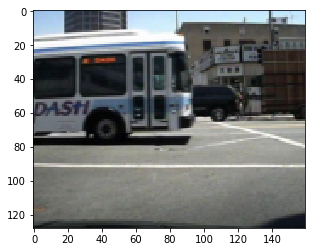

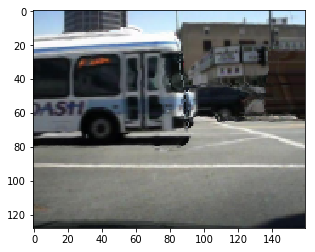

41


KeyboardInterrupt: 

In [61]:
for folder in folderList:
    print(folder)
    frames = [each for each in os.listdir(os.path.join(rootDir, folder)) if each.endswith(('.jpg','.jpeg','.bmp','png'))]
    frames.sort()
    print(len(frames))
    for i in range(25,100,1):
        sample = torch.FloatTensor(2, N_FRAME-1, 128*160)
        model,  dictionary, Drr, Dtheta = loadModel(ckpt_file)
        print(i)
        for ii in range(i, FRA+i): #for INCR WNDW range(25,FRA+i)
            imgname = os.path.join(rootDir,folder,frames[ii])
            img = Image.open(imgname)
            img1 = process_im(np.array(img))/255.

            imgname = os.path.join(rootDir,folder,frames[ii+1])
            img = Image.open(imgname)
            img2 = process_im(np.array(img))/255.

            u, v,_ = pyflow.coarse2fine_flow( img2, img1, alpha, ratio, minWidth,
                    nOuterFPIterations, nInnerFPIterations, nSORIterations, colType)
            
            flow = np.concatenate((u[..., None], v[..., None]), axis=2)
            flow = np.transpose(flow,(2,0,1))
            
            sample[:,ii-i,:] = torch.from_numpy(flow.reshape(2,128*160)).type(torch.FloatTensor) #for INCR WNDW sample[:,ii-25,:]
        
        #sample[0,0,10290] = 2
        alSample = alignOF(sample.view(2,9,128,160).unsqueeze(0),9)
        showOFs(alSample, sample.view(2,9,128,160).unsqueeze(0), 9)
        #alSample = sample
        imgname = os.path.join(rootDir,folder,frames[ii+2])
        img = Image.open(imgname)
        original = process_im(np.array(img))/255.

        imgname = os.path.join(rootDir,folder,frames[ii+1])
        img = Image.open(imgname)
        tenth = process_im(np.array(img))/255.

        inputData = alSample.cuda()
        #start = current_milli_time()
        with torch.no_grad():
            sparse = model.forward(Variable(inputData.view((2, 9, 128*160)).type(torch.FloatTensor).cuda(gpu_id)))
            c = sparse.cpu().numpy()
            c_list.append(c)
            
        ## INCREASING WINDOW  
        #N_FRAME += 1
        #T += 1
        
        prediction = torch.matmul(torch.t(dictionary),sparse)[:,FRA,:].data.permute(1,0).resize(128,160,2)
        
        tmp1 = torch.zeros((128,160, 3))
        tmp2 = torch.zeros((128,160, 3)) 
        tmp3 = torch.zeros((128,160, 3)) 
        tmp4 = torch.zeros((128,160, 3)) 
        tmp5 = torch.zeros((128,160, 3)) 
        
        tmp1[:,:,0:2] = prediction
        tmp2[:,:,0:2] = sample[:,FRA-2,:].view((2,128,160)).permute(1,2,0)
        tmp3[:,:,0:2] = sample[:,FRA-1,:].view((2,128,160)).permute(1,2,0)
        tmp4[:,:,0:2] = alSample[0,:,FRA-2,:,:].permute(1,2,0)
        tmp5[:,:,0:2] = alSample[0,:,FRA-1,:,:].permute(1,2,0)
        
        tmpt = torch.cat((tmp1, tmp2, tmp3, tmp4, tmp5), 0)
        scipy.misc.imsave('Pred.png', tmpt.detach().cpu().numpy())
        
        img_back = scipwarp(tenth,prediction[:,:,0],prediction[:,:,1])
        img_back = np.clip(img_back, 0, 1.)
        
        plt.imshow(original, cmap='gray')
        plt.show()
        plt.imshow(img_back, cmap='gray')
        plt.show()
        
        meanserror = np.mean( (img_back - original) ** 2 )
        mse.append(meanserror)
        peaksnr = 10*math.log10(1./meanserror)
        psnr.append(peaksnr)
        ssim.append(SSIM(original, img_back))
        
    print (np.mean(ssim), np.mean(psnr), np.mean(mse))
        
    print('done!')
